1  Подготовка

In [1]:
import pandas as pd
import numpy as np
import pathlib
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.iolib.table import SimpleTable

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

from catboost import Pool, CatBoostRegressor, cv
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('C:\\Users\\User\\Desktop\\База\\taxi.csv', index_col=[0], parse_dates=[0])
df.sort_index(inplace=True)

In [3]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
df.isna().sum()

num_orders    0
dtype: int64

Я загрузила и изучила данные. В таблице представлены данные о количестве заказов такси с ин-тервалом в 10 минут с 1 марта по 31 августа 2018 года. Пропусков нет.

2  Анализ

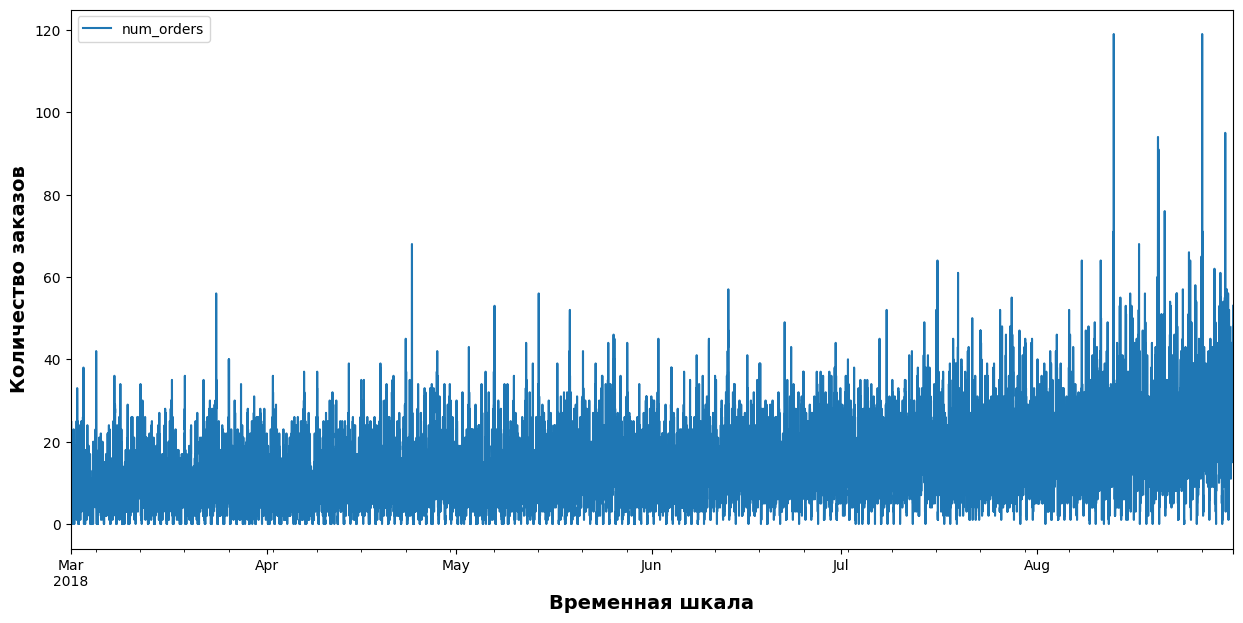

In [6]:
df.plot(figsize=(15,7))
plt.xlabel("Временная шкала", fontsize=14, fontweight="bold")
plt.ylabel("Количество заказов", fontsize=14, fontweight="bold");

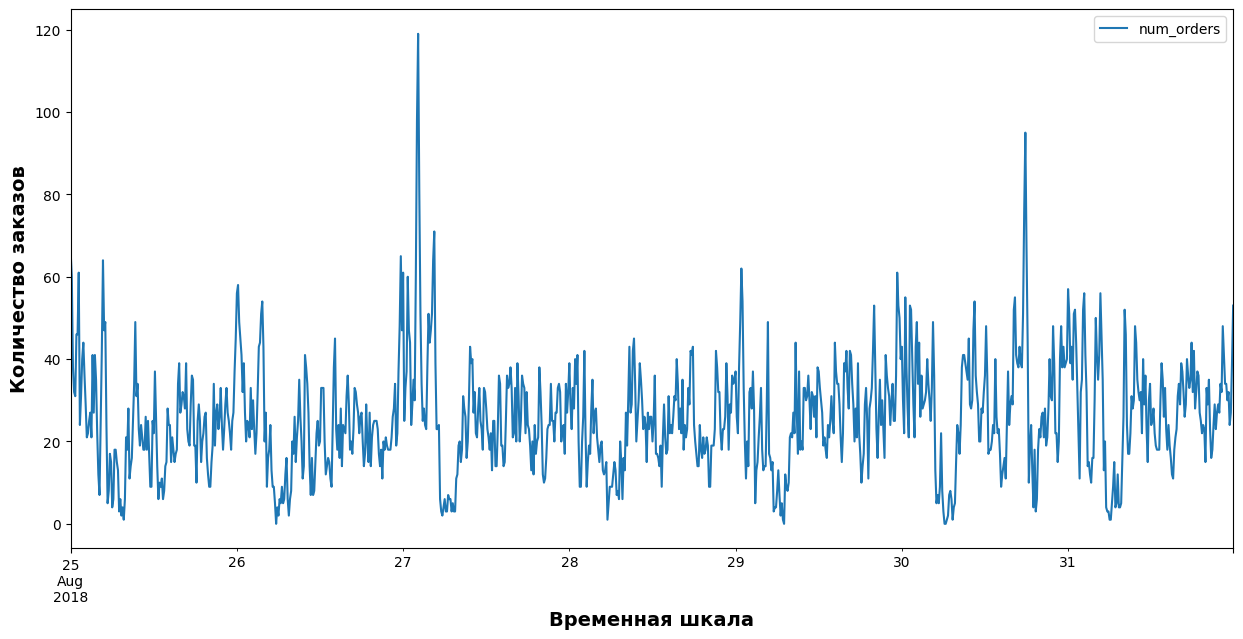

In [7]:
df['2018-08-25':'2018-08-31'].plot(figsize=(15,7))
plt.xlabel("Временная шкала", fontsize=14, fontweight="bold")
plt.ylabel("Количество заказов", fontsize=14, fontweight="bold");

Сделаю ресемплирование по одному часу.

In [8]:
df_rs = df.resample('1H').sum()

In [9]:
df_rs.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


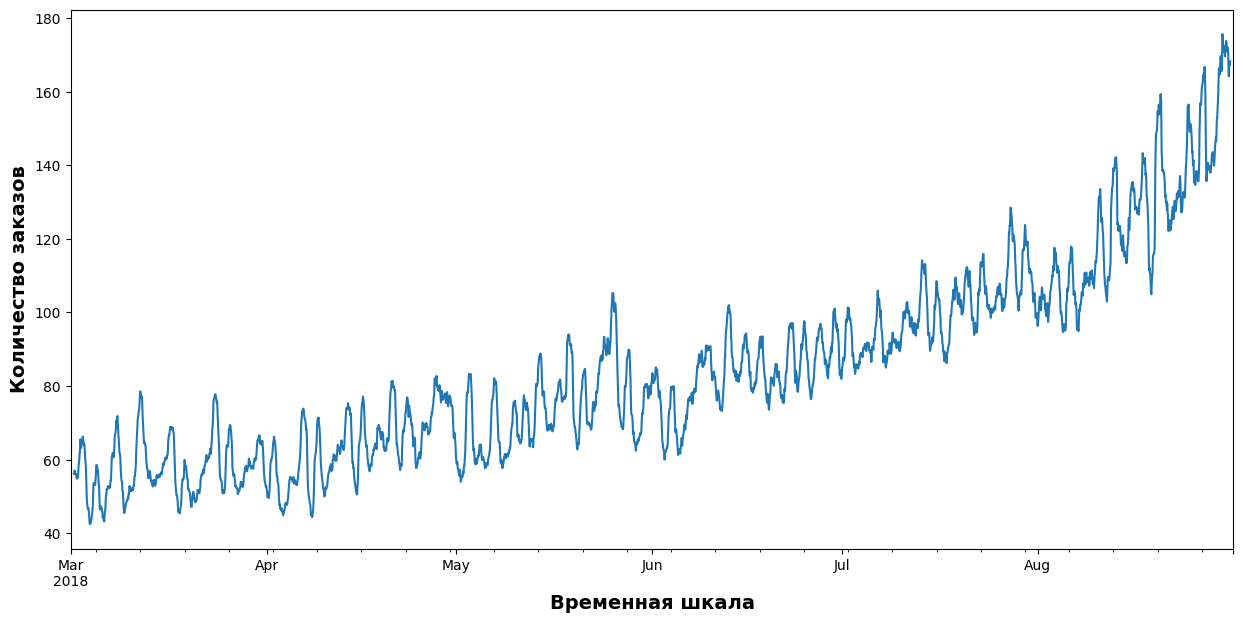

In [10]:
decomposed = seasonal_decompose(df_rs)
decomposed.trend.plot(figsize=(15,7))
plt.xlabel("Временная шкала", fontsize=14, fontweight="bold")
plt.ylabel("Количество заказов", fontsize=14, fontweight="bold");

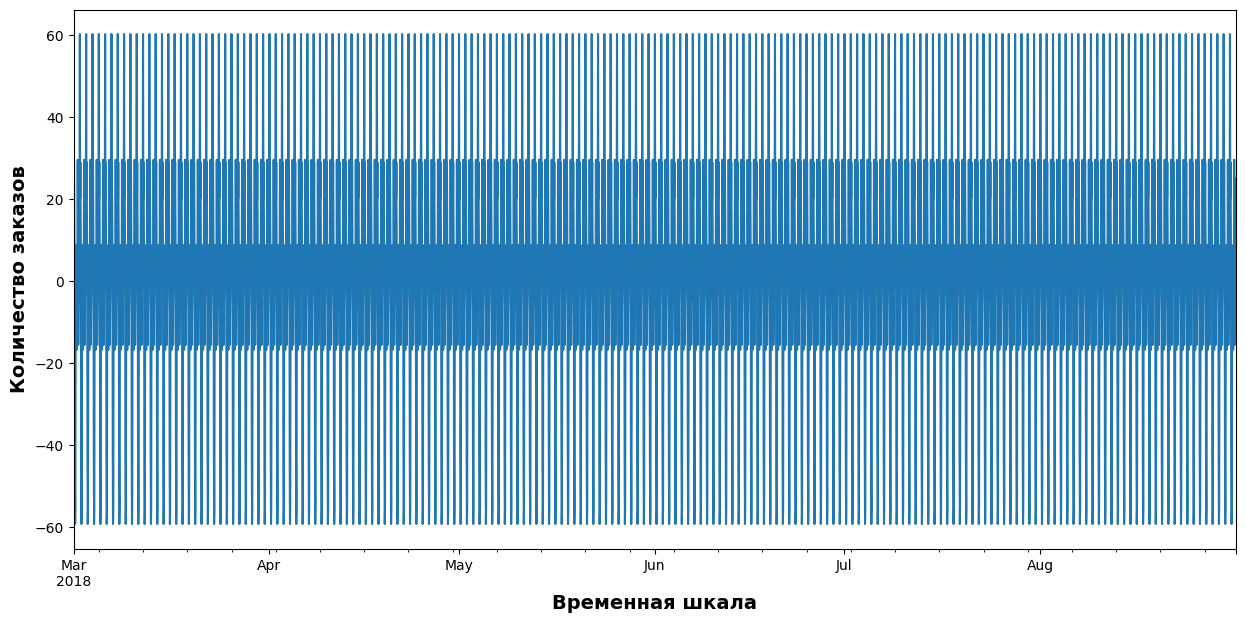

In [11]:
decomposed.seasonal.plot(figsize=(15,7))
plt.xlabel("Временная шкала", fontsize=14, fontweight="bold")
plt.ylabel("Количество заказов", fontsize=14, fontweight="bold");

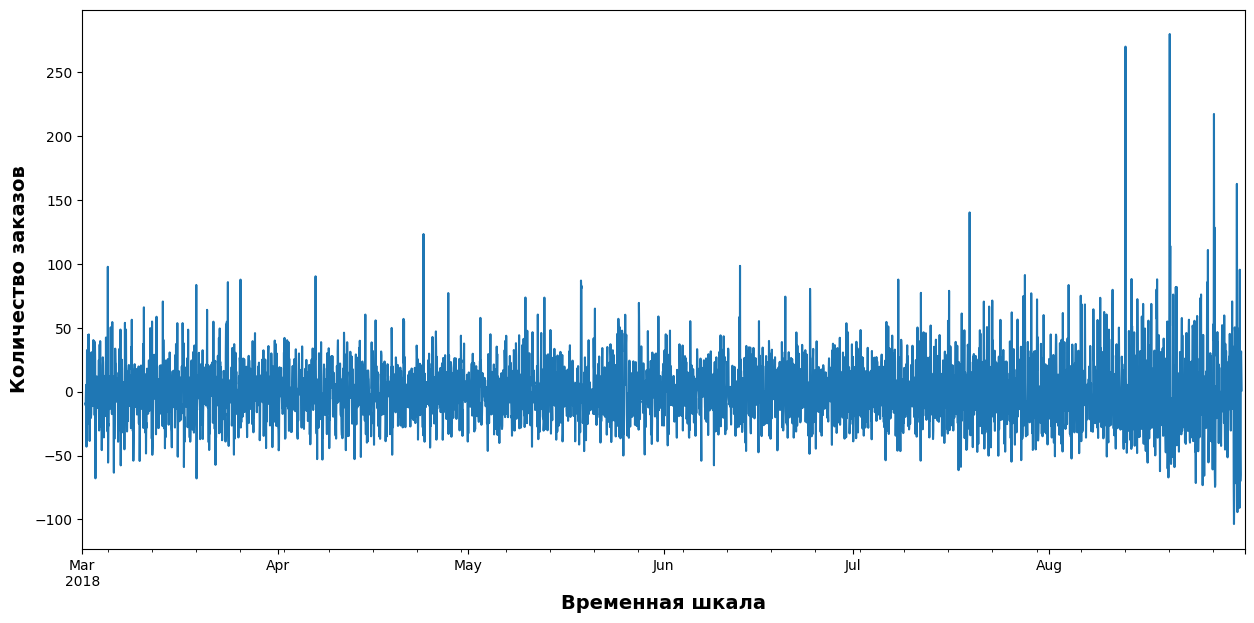

In [12]:
decomposed.resid.plot(figsize=(15,7))
plt.xlabel("Временная шкала", fontsize=14, fontweight="bold")
plt.ylabel("Количество заказов", fontsize=14, fontweight="bold");

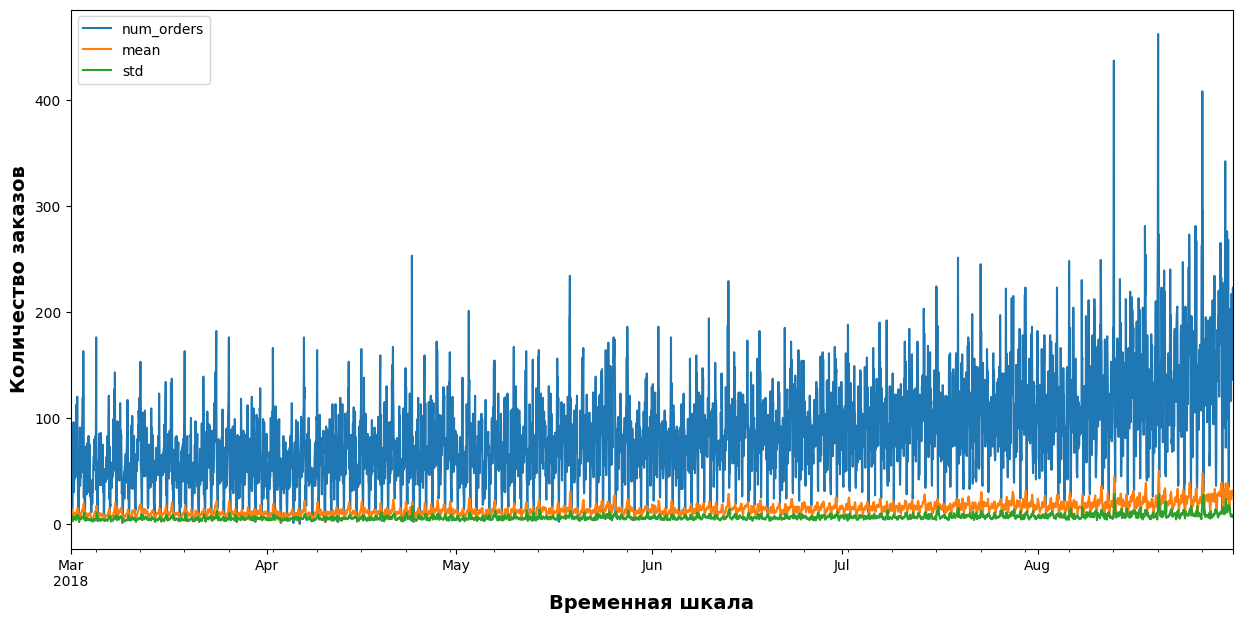

In [13]:
df_rs['mean'] = df['num_orders'].rolling(24).mean()
df_rs['std'] = df['num_orders'].rolling(24).std()
df_rs.plot(figsize=(15,7))
plt.xlabel("Временная шкала", fontsize=14, fontweight="bold")
plt.ylabel("Количество заказов", fontsize=14, fontweight="bold");

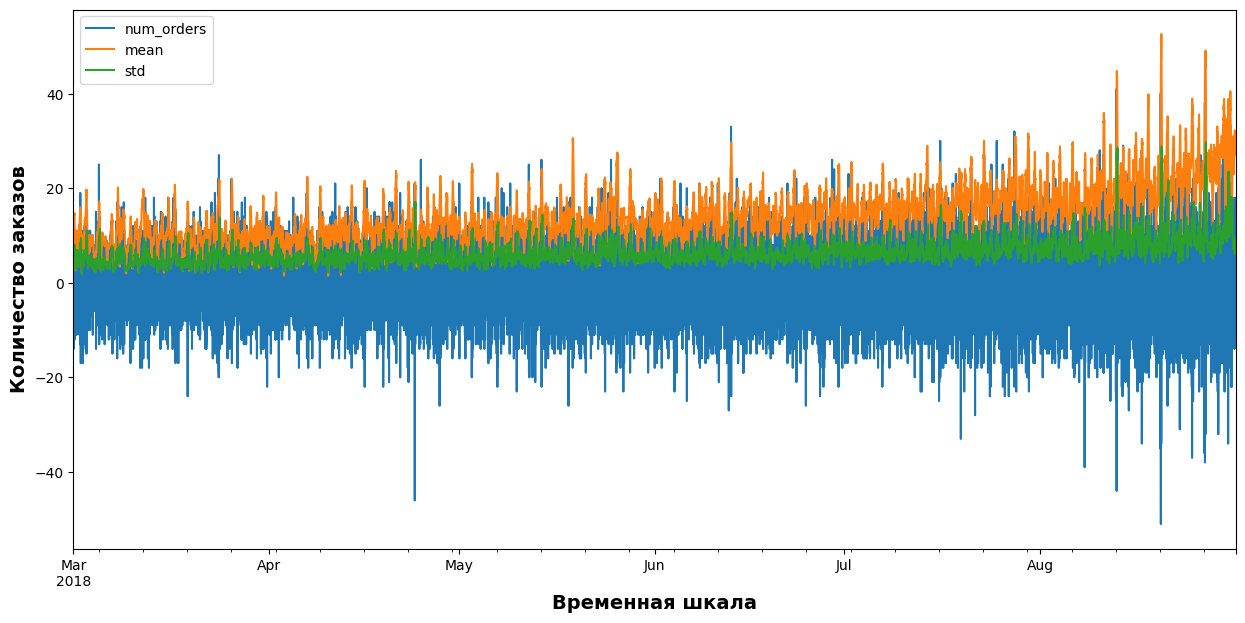

In [14]:
df_shift = df - df.shift()
df_shift['mean'] = df['num_orders'].rolling(24).mean()
df_shift['std'] = df['num_orders'].rolling(24).std()
df_shift.plot(figsize=(15,7))
plt.xlabel("Временная шкала", fontsize=14, fontweight="bold")
plt.ylabel("Количество заказов", fontsize=14, fontweight="bold");

count    4416.000000
mean       84.422781
std        45.023853
min         0.000000
25%        54.000000
50%        78.000000
75%       107.000000
max       462.000000
Name: num_orders, dtype: float64

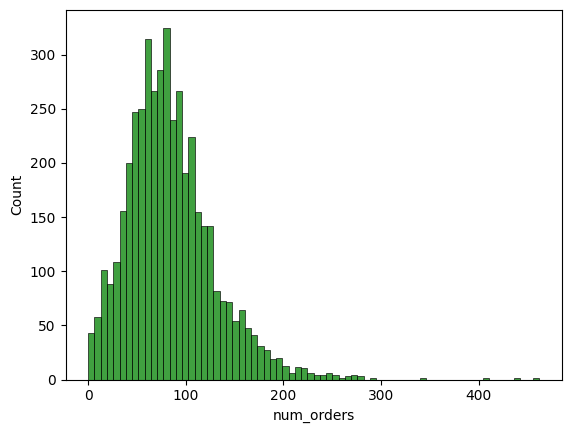

In [15]:
itog = df_rs['num_orders'].describe()
sns.histplot(df_rs['num_orders'], color='g', label='Количество заказов', kde=False)
itog

In [16]:
df_rs['num_orders'].describe()

count    4416.000000
mean       84.422781
std        45.023853
min         0.000000
25%        54.000000
50%        78.000000
75%       107.000000
max       462.000000
Name: num_orders, dtype: float64

In [17]:
print ('V = %f' % (itog['std']/itog['mean']))

V = 0.533314


In [18]:
row =  [u'JB', u'p-value', u'skew', u'kurtosis']
jb_test = sm.stats.stattools.jarque_bera(df)
a = np.vstack([jb_test])
itog = SimpleTable(a, row)
print (itog)

        JB        
------------------
36725.820538206615
               0.0
1.3965249518840612
 8.046287152641504
------------------


Проведу тест Дики-Фуллера.

In [19]:
otg1diff = df.diff(periods=1).dropna()

In [20]:
test = sm.tsa.adfuller(df['num_orders'])
print ('adf: ', test[0]) 
print ('p-value: ', test[1])
print ('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

adf:  -12.548885000267552
p-value:  2.228637881547835e-23
Critical values:  {'1%': -3.430597284562216, '5%': -2.861649292553069, '10%': -2.566828173184574}
единичных корней нет, ряд стационарен


In [21]:
df_rs.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   num_orders  4416 non-null   int64  
 1   mean        4412 non-null   float64
 2   std         4412 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 138.0 KB


In [22]:
del df_rs['mean']
del df_rs['std']

In [23]:
def resampling(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

resampling(df_rs, 24, 48)

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,4,19,207.0,217.0,197.0,116.0,133.0,166.0,136.0,...,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,72.0,170.895833
2018-08-31 20:00:00,154,4,20,136.0,207.0,217.0,197.0,116.0,133.0,166.0,...,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,170.208333
2018-08-31 21:00:00,159,4,21,154.0,136.0,207.0,217.0,197.0,116.0,133.0,...,78.0,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,169.437500


In [24]:
df_rs.dropna(inplace=True)

In [25]:
train, t = train_test_split(df_rs, shuffle=False, test_size=0.2, random_state=12345)

In [26]:
features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']

features_t = t.drop('num_orders', axis=1)
target_t = t['num_orders']

In [27]:
features_valid, features_test, target_valid, target_test = train_test_split(
    features_t, target_t, shuffle=False, test_size=0.5, random_state=12345)

In [28]:
print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)

(3494, 27)
(437, 27)
(437, 27)


In [29]:
features_train.columns

Index(['dayofweek', 'hour', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5',
       'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10', 'lag_11', 'lag_12',
       'lag_13', 'lag_14', 'lag_15', 'lag_16', 'lag_17', 'lag_18', 'lag_19',
       'lag_20', 'lag_21', 'lag_22', 'lag_23', 'lag_24', 'rolling_mean'],
      dtype='object')

In [30]:
numeric = ['dayofweek', 'hour', 'lag_1', 'lag_2', 'lag_3', 'lag_4',
       'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10', 'lag_11',
       'lag_12', 'lag_13', 'lag_14', 'lag_15', 'lag_16', 'lag_17', 'lag_18',
       'lag_19', 'lag_20', 'lag_21', 'lag_22', 'lag_23', 'lag_24',
       'rolling_mean']
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

Линейная регрессия.

In [31]:
model_lr = LinearRegression()
 
model_lr.fit(features_train, target_train)
 
pred_lr = model_lr.predict(features_valid)
rmse_lr = mean_squared_error(target_valid, pred_lr)**0.5
print("RMSE Линейное регрессии:", rmse_lr)

RMSE Линейное регрессии: 34.33326965576733


In [32]:
rmse_lr_cv = (cross_val_score(model_lr, features_valid, target_valid, cv=5, 
                             scoring='neg_mean_squared_error').mean() * -1) ** 0.5
rmse_lr_cv

36.156926980319845

Решающее дерево.

In [33]:
%%time
best_model = None
best_result = 0
best_depth = 0
for depth in range(2, 22, 2):
    model = DecisionTreeRegressor(random_state=12345, max_depth=depth)
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    result = mean_squared_error(target_valid, predictions)**0.5
    if result > best_result:
        best_model = model
        best_result = result
        best_depth = depth
model_tree = DecisionTreeRegressor(random_state=12345, max_depth=best_depth)
model_tree.fit(features_train, target_train)
pred_tree = model_tree.predict(features_valid)

rmse_tree = (cross_val_score(model_tree, features_valid, target_valid, cv=5, 
                             scoring='neg_mean_squared_error').mean() * -1) ** 0.5

print('RMSE модели Решающее дерево:', rmse_tree)

RMSE модели Решающее дерево: 36.69588803837855
CPU times: total: 547 ms
Wall time: 597 ms


Случайный лес.

In [34]:
%%time
best_model = None
best_result = 10000
best_est = 0
best_depth = 0
for est in range(10, 200, 10):
    for depth in range (2, 20):
        model = RandomForestRegressor (random_state=12345, n_estimators=est, max_depth= depth)
        model.fit(features_train, target_train) 
        predictions = model.predict(features_valid) 
        result = mean_squared_error(target_valid, predictions)**0.5 
        if result < best_result:
            best_model = model
            best_result = result
            best_est = est
            best_depth = depth
model_f = RandomForestRegressor (random_state=12345, n_estimators=best_est, max_depth= best_depth)
model_f.fit(features_train, target_train)

pred_f = model_f.predict(features_valid)

rmse_f = (cross_val_score(model_f, features_valid, target_valid, cv=5, 
                             scoring='neg_mean_squared_error').mean() * -1) ** 0.5

print('RMSE модели Случайный лес:', rmse_f)

RMSE модели Случайный лес: 32.221657316949994
CPU times: total: 17min 50s
Wall time: 17min 56s


Градиентный бустинг LightGBM.

In [35]:
%%time 

model_lgbm = LGBMRegressor(n_estimators=1000, random_state=123, learning_rate=0.2, objective='rmse')
model_lgbm.fit(features_train, target_train, eval_set=(features_valid, target_valid), verbose=100)

pred_lgbm = model_lgbm.predict(features_valid)

rmse_lgbm = (cross_val_score(model_lgbm, features_valid, target_valid, cv=5, 
                             scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('RMSE модели Градиентный бустинг LightGBM:', rmse_lgbm)

[100]	valid_0's rmse: 32.3592
[200]	valid_0's rmse: 32.7209
[300]	valid_0's rmse: 32.7692
[400]	valid_0's rmse: 32.8026
[500]	valid_0's rmse: 32.8101
[600]	valid_0's rmse: 32.8166
[700]	valid_0's rmse: 32.8189
[800]	valid_0's rmse: 32.8184
[900]	valid_0's rmse: 32.8193
[1000]	valid_0's rmse: 32.8195
RMSE модели Градиентный бустинг LightGBM: 35.5841858713401
CPU times: total: 8.91 s
Wall time: 2.72 s


Градиентный бустинг CatBoost.

In [36]:
%%time


model_cat = CatBoostRegressor(random_state=123, learning_rate=0.085, verbose=20, n_estimators=500)
model_cat.fit(features_train, target_train, eval_set=(features_valid, target_valid))

pred_cat = model_cat.predict(features_valid)

rmse_cat = (cross_val_score(model_cat, features_valid, target_valid, cv=5, 
                             scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('RMSE модели Градиентный бустинг CatBoost:', rmse_cat)

0:	learn: 34.3475408	test: 56.6260901	best: 56.6260901 (0)	total: 99.6ms	remaining: 49.7s
20:	learn: 23.3048116	test: 40.3059467	best: 40.3059467 (20)	total: 197ms	remaining: 4.49s
40:	learn: 21.1627888	test: 35.6989946	best: 35.6989946 (40)	total: 288ms	remaining: 3.22s
60:	learn: 20.1207728	test: 34.0207392	best: 34.0207392 (60)	total: 372ms	remaining: 2.68s
80:	learn: 19.3628956	test: 33.2082504	best: 33.2082504 (80)	total: 453ms	remaining: 2.34s
100:	learn: 18.6813476	test: 33.1002192	best: 33.0429332 (94)	total: 533ms	remaining: 2.1s
120:	learn: 18.0929750	test: 32.6468478	best: 32.6468478 (120)	total: 617ms	remaining: 1.93s
140:	learn: 17.5583151	test: 32.4549343	best: 32.3359959 (134)	total: 718ms	remaining: 1.83s
160:	learn: 16.9856682	test: 32.3194486	best: 32.2168588 (155)	total: 806ms	remaining: 1.7s
180:	learn: 16.5146200	test: 32.1864131	best: 32.1403003 (177)	total: 896ms	remaining: 1.58s
200:	learn: 16.0346376	test: 32.1630002	best: 32.1403003 (177)	total: 976ms	remainin

4  Тестирование

Проведу тестирование моделей на тестовой выборке.

In [37]:
pred_lr_test = model_lr.predict(features_test)
rmse_lr_test = mean_squared_error(target_test, pred_lr_test)**0.5

print("RMSE Линейное регрессии:", rmse_lr_test)

RMSE Линейное регрессии: 45.646662701920164


In [38]:
pred_tree_test = model_tree.predict(features_test)
rmse_tree_test = mean_squared_error(target_test, pred_tree_test)**0.5

print('RMSE модели Решающее дерево:', rmse_tree_test)

RMSE модели Решающее дерево: 70.52931323013316


In [39]:
pred_f_test = model_f.predict(features_test)
rmse_f_test = mean_squared_error(target_test, pred_f_test)**0.5

print('RMSE модели Случайный лес:', rmse_f_test)

RMSE модели Случайный лес: 49.671046282500335


In [40]:
pred_lgbm_test = model_lgbm.predict(features_test)
rmse_lgbm_test = mean_squared_error(target_test, pred_lgbm_test)**0.5

print('RMSE модели Градиентный бустинг LightGBM:', rmse_lgbm_test)

RMSE модели Градиентный бустинг LightGBM: 54.04841354692087


In [41]:
pred_cat_test = model_cat.predict(features_test)
rmse_cat_test = mean_squared_error(target_test, pred_cat_test)**0.5

print('RMSE модели Градиентный бустинг CatBoost:', rmse_cat_test)

RMSE модели Градиентный бустинг CatBoost: 54.13604608457049


In [42]:
comparison = pd.DataFrame(
    {'Метрики': ['Линейная регрессия', 'Решающее дерево', 'Случайный лес', 'ГБ LightGBM', 'ГБ CatBoost'],
     'RMSE на валидационной выборке': [rmse_lr, rmse_tree, rmse_f, rmse_lgbm, rmse_cat], 
     'RMSE на тестовой выборке': [rmse_lr_test, rmse_tree_test, rmse_f_test, rmse_lgbm_test, rmse_cat_test]}
)
print(comparison)

              Метрики  RMSE на валидационной выборке  RMSE на тестовой выборке
0  Линейная регрессия                      34.333270                 45.646663
1     Решающее дерево                      36.695888                 70.529313
2       Случайный лес                      32.221657                 49.671046
3         ГБ LightGBM                      35.584186                 54.048414
4         ГБ CatBoost                      32.080771                 54.136046


Вывод:
Я загрузила данные, изучила и проанализировала их. Необходимо было обучить разные модели машинного обучения и подобрать гиперпараметры так, чтобы метрика RMSE была ниже 48.
Я обучила пять моделей 'Линейная регрессия', 'Решающее дерево', 'Случайный лес', 'ГБ LightGBM', 'ГБ CatBoost' с разными гиперпараметрами. Модели Линейная регрессия и Решающее дерево показалирезультат метрики RMSE на тестовой выборке больше требуемой, а остальные - меньше требуемой. Наименьшее RMSE показала модель градиентного бустинга CatBoost - 43.55.
Следовательно я делаю выдод, что модель градиентного бустинга CatBoost лучше других подходит для пресказания количества заказов на посделующий час.
